In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = "yahoo_data.xlsx"
df = pd.read_excel(file_path)

df.rename(columns={"Close*": "Close", "Adj Close**": "Adj_Close"}, inplace=True)

# Step 2: Inspect the dataset
print("First 5 rows:")
print(df.head())
print("\nSummary:")
print(df.info())


First 5 rows:
           Date      Open      High       Low     Close  Adj_Close     Volume
0  Apr 28, 2023  33797.43  34104.56  33728.40  34098.16   34098.16  354310000
1  Apr 27, 2023  33381.66  33859.75  33374.65  33826.16   33826.16  343240000
2  Apr 26, 2023  33596.34  33645.83  33235.85  33301.87   33301.87  321170000
3  Apr 25, 2023  33828.34  33875.49  33525.39  33530.83   33530.83  297880000
4  Apr 24, 2023  33805.04  33891.15  33726.09  33875.40   33875.40  252020000

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj_Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
me

In [2]:
# Check for null values
print("Null values in each column:")
print(df.isnull().sum())


Null values in each column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


In [3]:
# Step 2: Data Sorting
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)

# Step 3: Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_columns = ["Open", "High", "Low", "Close", "Volume"]
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

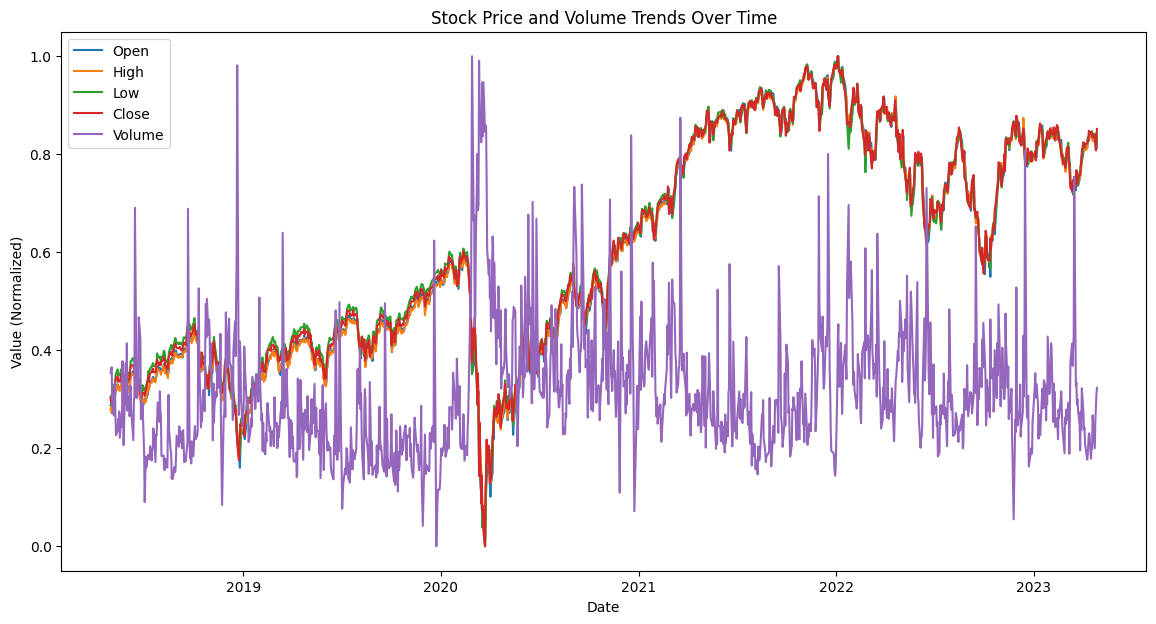

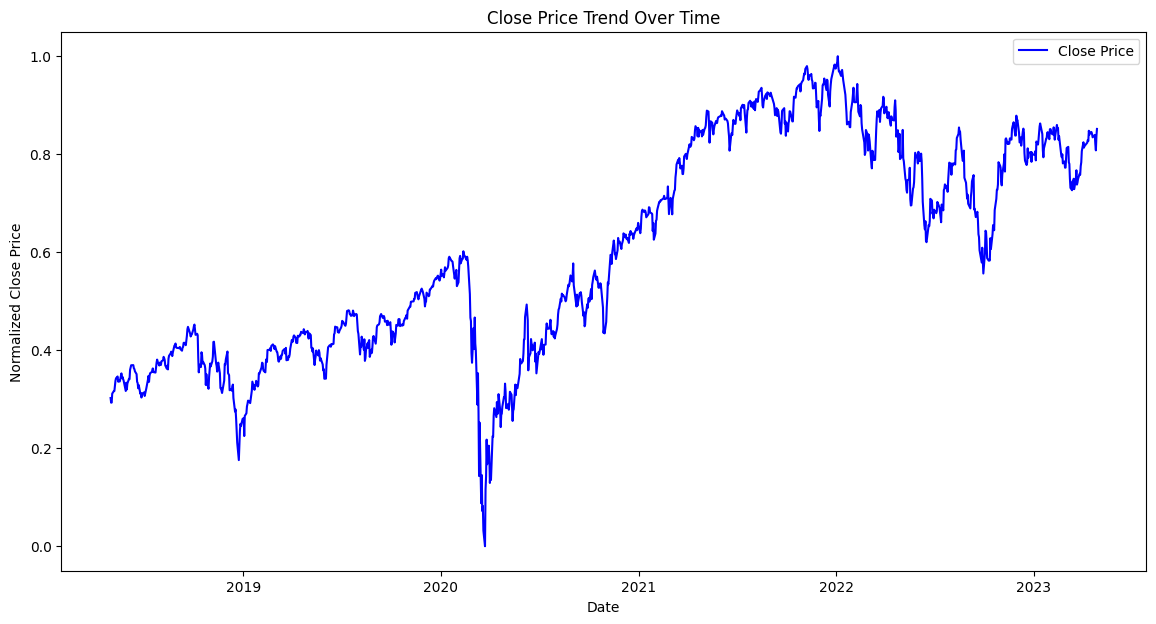

In [4]:
# Plotting each column over time
plt.figure(figsize=(14, 7))
for column in ["Open", "High", "Low", "Close", "Volume"]:
    plt.plot(df["Date"], df[column], label=column)

plt.title("Stock Price and Volume Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Value (Normalized)")
plt.legend()
plt.show()

# Plot Close price separately for better focus
plt.figure(figsize=(14, 7))
plt.plot(df["Date"], df["Close"], label="Close Price", color="blue")
plt.title("Close Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Step 4: Feature Engineering
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Target: Close price
    return np.array(X), np.array(y)

seq_length = 60
data = df[["Open", "High", "Low", "Close", "Volume"]].values
X, y = create_sequences(data, seq_length)

# Step 5: Train/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)


Training Data Shape: (838, 60, 5)
Validation Data Shape: (180, 60, 5)
Test Data Shape: (180, 60, 5)


In [7]:
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import numpy as np

# Dataset conversion
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))

def train_and_evaluate_model(trial, model_type="LSTM"):
    """
    Train and evaluate LSTM/GRU model with given hyperparameters.
    """
    # Hyperparameter suggestions
    num_layers = trial.suggest_int("num_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model selection
    if model_type == "LSTM":
        model = LSTMModel(input_size=5, hidden_size=hidden_size, num_layers=num_layers)
    elif model_type == "GRU":
        model = GRUModel(input_size=5, hidden_size=hidden_size, num_layers=num_layers)

    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training
    num_epochs = 20
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    return val_loss

# Define the LSTM/GRU models
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

# Objective function for Optuna
def objective_lstm(trial):
    return train_and_evaluate_model(trial, model_type="LSTM")

def objective_gru(trial):
    return train_and_evaluate_model(trial, model_type="GRU")

# Run Optuna studies
print("Optimizing LSTM...")
lstm_study = optuna.create_study(direction="minimize")
lstm_study.optimize(objective_lstm, n_trials=30)

print("Best LSTM Hyperparameters:", lstm_study.best_params)

print("Optimizing GRU...")
gru_study = optuna.create_study(direction="minimize")
gru_study.optimize(objective_gru, n_trials=30)

print("Best GRU Hyperparameters:", gru_study.best_params)


[I 2024-11-26 14:17:51,935] A new study created in memory with name: no-name-5d17136d-a4a7-4c4f-bbe9-2b1f3fbd7583


Optimizing LSTM...


C:\Users\Kunal\AppData\Local\Temp\ipykernel_24664\1430481937.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2024-11-26 14:18:03,881] Trial 0 finished with value: 0.0018100528201709192 and parameters: {'num_layers': 2, 'hidden_size': 93, 'learning_rate': 0.0004850690596953302, 'batch_size': 64}. Best is trial 0 with value: 0.0018100528201709192.
[I 2024-11-26 14:18:13,147] Trial 1 finished with value: 0.0006278814095518707 and parameters: {'num_layers': 1, 'hidden_size': 56, 'learning_rate': 0.005637512314217379, 'batch_size': 16}. Best is trial 1 with value: 0.0006278814095518707.
[I 2024-11-26 14:18:22,793] Trial 2 finished with value: 0.0008519159164279699 and parameters: {'num_layers': 1, 'hidden_size': 67, 'learning_rate': 0.0007325292180717427, 

Best LSTM Hyperparameters: {'num_layers': 3, 'hidden_size': 116, 'learning_rate': 0.004064579845725523, 'batch_size': 16}
Optimizing GRU...


[I 2024-11-26 14:29:57,456] Trial 0 finished with value: 0.0005157644785261558 and parameters: {'num_layers': 3, 'hidden_size': 48, 'learning_rate': 0.007068064729203934, 'batch_size': 16}. Best is trial 0 with value: 0.0005157644785261558.
[I 2024-11-26 14:31:05,712] Trial 1 finished with value: 0.0008551536666345783 and parameters: {'num_layers': 2, 'hidden_size': 62, 'learning_rate': 0.007980906754732333, 'batch_size': 16}. Best is trial 0 with value: 0.0005157644785261558.
[I 2024-11-26 14:31:35,044] Trial 2 finished with value: 0.0010094423584329586 and parameters: {'num_layers': 3, 'hidden_size': 35, 'learning_rate': 0.0011144946231710685, 'batch_size': 64}. Best is trial 0 with value: 0.0005157644785261558.
[I 2024-11-26 14:31:46,761] Trial 3 finished with value: 0.0009271316812373698 and parameters: {'num_layers': 1, 'hidden_size': 65, 'learning_rate': 0.0005123431163091185, 'batch_size': 64}. Best is trial 0 with value: 0.0005157644785261558.
[I 2024-11-26 14:32:14,896] Trial 

Best GRU Hyperparameters: {'num_layers': 2, 'hidden_size': 71, 'learning_rate': 0.006161452840526374, 'batch_size': 16}


In [8]:
# Visualize optimization results
optuna.visualization.plot_optimization_history(lstm_study).show()
optuna.visualization.plot_optimization_history(gru_study).show()

optuna.visualization.plot_param_importances(lstm_study).show()
optuna.visualization.plot_param_importances(gru_study).show()

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Best hyperparameters from optimization
best_lstm_params = {'num_layers': 3, 'hidden_size': 116, 'learning_rate': 0.004064579845725523, 'batch_size': 16}

best_gru_params = {'num_layers': 2, 'hidden_size': 71, 'learning_rate': 0.006161452840526374, 'batch_size': 16}

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Define DataLoader with best batch size
train_loader_lstm = DataLoader(train_dataset, batch_size=best_lstm_params["batch_size"], shuffle=True)
val_loader_lstm = DataLoader(val_dataset, batch_size=best_lstm_params["batch_size"])
test_loader_lstm = DataLoader(test_dataset, batch_size=best_lstm_params["batch_size"])

train_loader_gru = DataLoader(train_dataset, batch_size=best_gru_params["batch_size"], shuffle=True)
val_loader_gru = DataLoader(val_dataset, batch_size=best_gru_params["batch_size"])
test_loader_gru = DataLoader(test_dataset, batch_size=best_gru_params["batch_size"])

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize models with best hyperparameters
lstm_model = LSTMModel(input_size=5, hidden_size=best_lstm_params["hidden_size"], num_layers=best_lstm_params["num_layers"])
gru_model = GRUModel(input_size=5, hidden_size=best_gru_params["hidden_size"], num_layers=best_gru_params["num_layers"])

# Define loss function and optimizers with best learning rates
criterion = nn.MSELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=best_lstm_params["learning_rate"])
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=best_gru_params["learning_rate"])

class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change in the monitored value to be considered an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.squeeze().numpy())
            actuals.extend(y_batch.numpy())
    mse = mean_squared_error(actuals, predictions)
    return predictions, actuals, mse

# Updated training function with Early Stopping
def train_model_with_early_stopping(model, optimizer, train_loader, val_loader, num_epochs=20, patience=3):
    train_losses, val_losses = [], []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

# Train LSTM with Early Stopping
print("Training LSTM with Early Stopping...")
lstm_train_losses, lstm_val_losses = train_model_with_early_stopping(
    lstm_model, lstm_optimizer, train_loader_lstm, val_loader_lstm, num_epochs=20, patience=3
)

# Train GRU with Early Stopping
print("Training GRU with Early Stopping...")
gru_train_losses, gru_val_losses = train_model_with_early_stopping(
    gru_model, gru_optimizer, train_loader_gru, val_loader_gru, num_epochs=20, patience=3
)

# Evaluate both models
lstm_predictions, lstm_actuals, lstm_mse = evaluate_model(lstm_model, test_loader_lstm)
gru_predictions, gru_actuals, gru_mse = evaluate_model(gru_model, test_loader_gru)

print(f"LSTM Test MSE: {lstm_mse:.4f}")
print(f"GRU Test MSE: {gru_mse:.4f}")


Training LSTM with Early Stopping...
Epoch 1/20, Train Loss: 0.0286, Val Loss: 0.0030
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 3/20, Train Loss: 0.0017, Val Loss: 0.0014
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0015
Epoch 6/20, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0008, Val Loss: 0.0010
Epoch 9/20, Train Loss: 0.0008, Val Loss: 0.0007
Epoch 10/20, Train Loss: 0.0008, Val Loss: 0.0007
Epoch 11/20, Train Loss: 0.0006, Val Loss: 0.0006
Epoch 12/20, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 13/20, Train Loss: 0.0006, Val Loss: 0.0007
Epoch 14/20, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 15/20, Train Loss: 0.0006, Val Loss: 0.0007
Epoch 16/20, Train Loss: 0.0009, Val Loss: 0.0015
Epoch 17/20, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 18/20, Train Loss: 0.0005, Val Loss: 0.0010
Epoch 19/20, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 20/20, Train Los

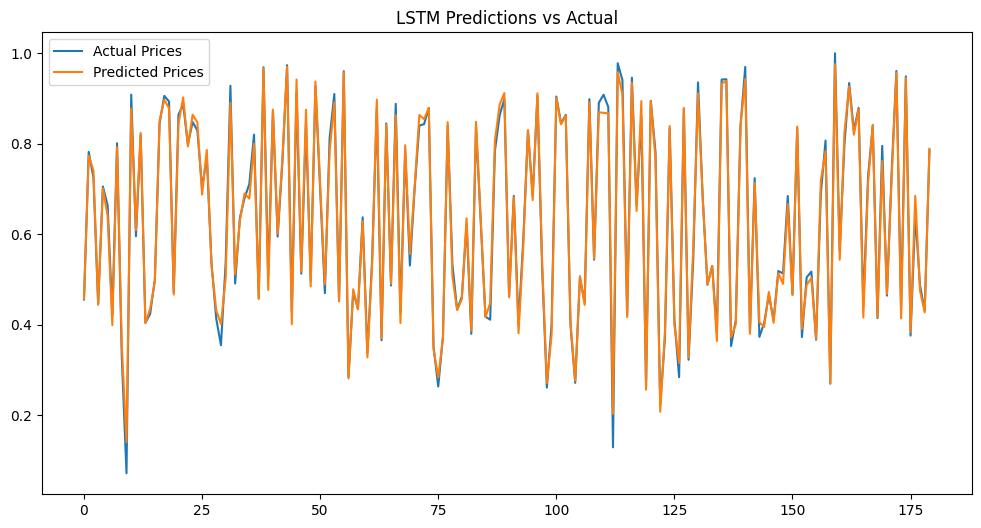

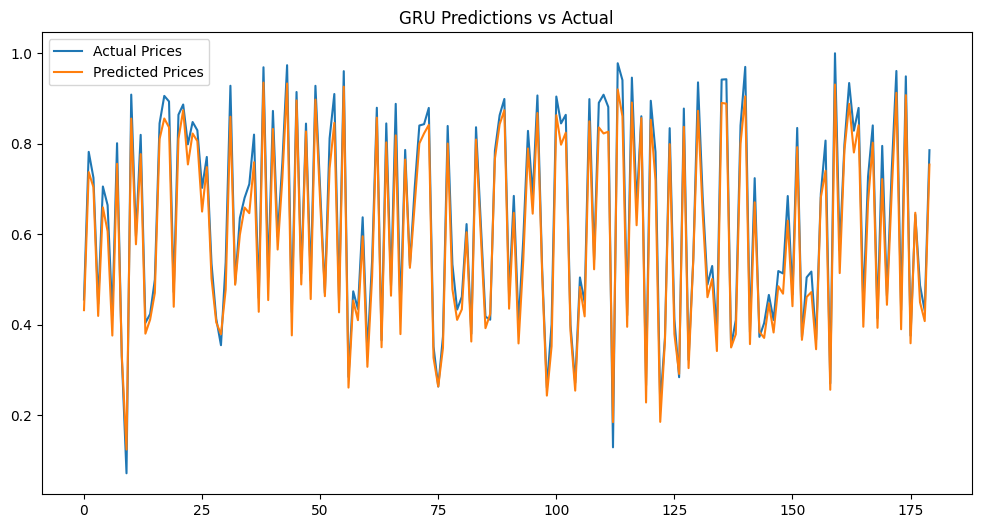

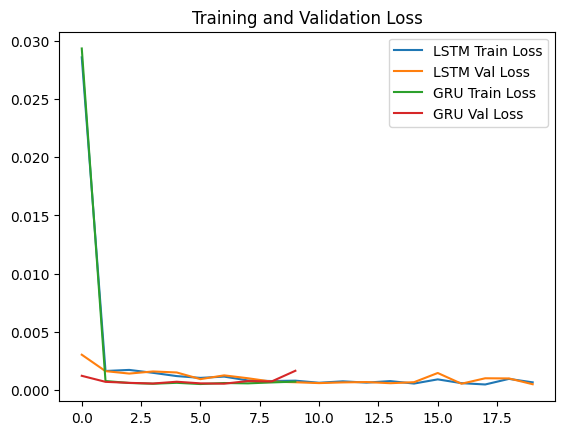

In [11]:
# Visualizations
def plot_predictions(actuals, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label="Actual Prices")
    plt.plot(predictions, label="Predicted Prices")
    plt.title(title)
    plt.legend()
    plt.show()

plot_predictions(lstm_actuals, lstm_predictions, "LSTM Predictions vs Actual")
plot_predictions(gru_actuals, gru_predictions, "GRU Predictions vs Actual")

# Training and Validation Loss Visualization
plt.plot(lstm_train_losses, label="LSTM Train Loss")
plt.plot(lstm_val_losses, label="LSTM Val Loss")
plt.plot(gru_train_losses, label="GRU Train Loss")
plt.plot(gru_val_losses, label="GRU Val Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# # Evaluation function with additional metrics
# def evaluate_model_with_metrics(model, test_loader):
#     model.eval()
#     predictions, actuals = [], []
#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             y_pred = model(X_batch)
#             predictions.extend(y_pred.squeeze().numpy())
#             actuals.extend(y_batch.numpy())

#     mse = mean_squared_error(actuals, predictions)
#     mape = mean_absolute_percentage_error(actuals, predictions)
#     r2 = r2_score(actuals, predictions)

#     return predictions, actuals, mse, mape, r2

# # Evaluate LSTM model
# lstm_predictions, lstm_actuals, lstm_mse, lstm_mape, lstm_r2 = evaluate_model_with_metrics(lstm_model, test_loader_lstm)

# # Evaluate GRU model
# gru_predictions, gru_actuals, gru_mse, gru_mape, gru_r2 = evaluate_model_with_metrics(gru_model, test_loader_gru)

# # Display results
# print(f"LSTM Test MSE: {lstm_mse:.4f}")
# print(f"LSTM Test MAPE: {lstm_mape:.4f}")
# print(f"LSTM Test R² Score: {lstm_r2:.4f}")

# print(f"GRU Test MSE: {gru_mse:.4f}")
# print(f"GRU Test MAPE: {gru_mape:.4f}")
# print(f"GRU Test R² Score: {gru_r2:.4f}")
